In [1]:
from time import time
import numpy as np
import logging
from pprint import pprint, pformat
import random
from collections import namedtuple
from copy import deepcopy
from multiprocessing import Pool
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

Nimply = namedtuple("Nimply", "row, num_objects")

/var/folders/2y/_ycqdwxs44z50d53gg4hp92w0000gn/T/ipykernel_22113/3707614075.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

In [3]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

In [4]:
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])

    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict:
    candidate = dict()
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        candidate[ply] = nim_sum(tmp)
    return candidate


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis.items() if ns != 0]
    if not spicy_moves:
        spicy_moves = list(analysis.keys())
    ply = random.choice(spicy_moves)
    return ply


def new_optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [ply for ply, ns in analysis.items() if ns == 1]
    if not spicy_moves:
        spicy_moves = list(analysis.keys())
    ply = random.choice(spicy_moves)
    return ply

In [5]:
game = Nim(3)
ply = Nimply(0, 1)
game.nimming(ply)
nim_sum(game)

6

In [6]:
def nim_game(num_rows: int, strategy1, strategy2) -> bool:
    """
    Simulate a game against two strategies
    strategy1 : function handle that define the strategy of the first player
    strategy2 : function handle that define the strategy of the second player
    returns True if the first strategy won
    """
    strategies = [strategy1, strategy2]
    nim = Nim(num_rows)
    player = 0
    while nim:
        move = strategies[player](nim)
        nim.nimming(move)
        player = 1 - player

    return player == 0


def simulate_games(num_games: int, num_rows: int, strategy1, strategy2) -> float:
    """Function that makes two strategies play against each other 2 times alternating who playes first
    returns percentage of wins of the first strategy
    """
    wins = 0
    for _ in range(num_games):
        if nim_game(num_rows, strategy1, strategy2):
            wins += 1
        if not nim_game(num_rows, strategy2, strategy1):
            wins += 1

    return wins / (2 * num_games)


def simulate_games_all(num_games: int, num_rows: int, strategy1) -> float:
    """
    Function that makes a single strategy play against all the strategy already known (pure_random, gabriele and optimal) and also a new strategy new_optimal
    makes them play a total of 10 games alterning who playes first
    returns percentage of wins of the tested strategy
    """
    wins = 0
    for _ in range(num_games):
        for j in range(3):
            if nim_game(num_rows, strategy1, pure_random):
                wins += 1
            if not nim_game(num_rows, pure_random, strategy1):
                wins += 1
        if nim_game(num_rows, strategy1, optimal):
            wins += 1
        if not nim_game(num_rows, optimal, strategy1):
            wins += 1
        if nim_game(num_rows, strategy1, new_optimal):
            wins += 1
        if not nim_game(num_rows, new_optimal, strategy1):
            wins += 1

    return wins / (10 * num_games)

In [7]:
def policy(args):
    """
    This function defines returns a function handle that acts as a strategy defined from the args
    """

    def strategy(nim: Nim):
        """Strategy that chooses the move that has the maximum value of arg correspondig to the nimsum"""
        analysis = analize(nim)
        population = list()
        weights = list()
        for ply, ns in analysis.items():
            population.append(ply)
            weights.append(args[ns])

        # ply = random.choices(population=population, weights=weights, k=1)[0]
        return population[np.argmax(weights)]

    return strategy


def fitness1(n_rows: int, n_games: int, strategy2):
    """Fitness evaluated against a specified strategy"""

    def fitness_func(args) -> float:
        strategy1 = policy(args)
        return simulate_games(n_games, n_rows, strategy1, strategy2)

    return fitness_func


def fitness2(n_rows: int, n_games: int):
    """Fitness evaluated against all the strategies"""

    def fitness_func(args) -> float:
        strategy1 = policy(args)
        return simulate_games_all(n_games, n_rows, strategy1)

    return fitness_func


def fitness3(n_rows: int, n_games: int):
    """Fitness evaluated between two indiidual of the population"""

    def fitness_func(arg1, arg2) -> float:
        strategy1 = policy(arg1)
        strategy2 = policy(arg2)

        return simulate_games(n_games, n_rows, strategy1, strategy2)

    return fitness_func

In [8]:
def ES_1_plus_lambda(_function, N_DIM, n_offspring=1_000):
    """
    Evolution strategy function that optimize a vector of dimension N_DIM using the fitness funnction _function
    _function : function handle of the fitness function to evaluate the parameters
    N_DIM: int dimension of the vectors of the parameter
    n_offspring : the total number of new individual that will be produced during the execution

    returns tuple containing the best 'genome' and the history of the best fitness function found
    """
    λ = 25
    σ = 0.1

    solution = np.random.normal(loc=0, scale=σ, size=N_DIM)
    history = list()
    best_so_far = np.copy(solution)
    best_eval = _function(solution)

    stats = [0, 0]
    for step in tqdm(range(n_offspring // λ)):
        samples = np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
        samples_evals = np.array([_function(samples[i]) for i in range(λ)])

        stats[0] += λ
        stats[1] += sum(samples_evals > best_eval)

        best_offspring = np.argmax(samples_evals)
        solution = samples[best_offspring]

        if best_eval < samples_evals[best_offspring]:
            best_eval = samples_evals[best_offspring]
            best_so_far = np.copy(solution) / np.max(solution)
            history.append((step, samples_evals[best_offspring]))

        # self adaptation every 10 generation
        if (step + 1) % 10 == 0:
            if stats[1] == 0 or stats[0] / stats[1] > 1 / 5:
                σ *= 1.1
            elif stats[0] / stats[1] < 1 / 5:
                σ *= 0.9
            stats = [0, 0]
    # print(σ)
    return best_so_far, history

In [9]:
def ES_1_plus_lambda_against(_function, N_ROWS, N_DIM, n_offspring=1_000):
    """
    Evolution strategy function that optimize a vector of dimension N_DIM using the fitness funnction _function
    _function : function handle of the fitness function to evaluate the parameters. In this case the fitness function compares two individual of the population
        _function(arg1, arg2) gives the fitness of of arg1 compared to arg2
    N_DIM: int dimension of the vectors of the parameter
    n_offspring : the total number of new individual that will be produced during the execution

    returns tuple containing the best 'genome' and the history of the best fitness function found
    """
    λ = 5
    σ = 0.75

    solution = np.random.normal(loc=0, scale=σ, size=N_DIM)
    history = list()
    best_so_far = np.copy(solution)

    for step in tqdm(range(n_offspring // λ)):
        samples = np.random.normal(loc=0, scale=σ, size=(λ, N_DIM)) + solution
        # make them play all with each other
        samples_evals = np.array([0 for i in range(λ)])
        for i in range(λ):
            for j in range(i, λ):
                if i == j:
                    # instead of playing with itself plays against the random
                    samples_evals[i] += fitness1(
                        n_games=2, n_rows=N_ROWS, strategy2=pure_random
                    )(samples[i])
                else:
                    result = _function(samples[i], samples[j])
                    samples_evals[i] += result
                    samples_evals[j] += 1 - result

        # takes the mean number of success in the tournament
        samples_evals = samples_evals / (λ)

        best_offspring = np.argmax(samples_evals)
        solution = samples[best_offspring]

        # we chack if the best offspring we created is able to beat the champion more then 50% of the time
        if _function(best_so_far, solution) < 0.5:
            best_so_far = np.copy(solution) / np.max(solution)
            history.append((step, samples_evals[best_offspring]))

    return best_so_far, history

In [10]:
def ES_mu_plus_lambda(_function, N_DIM, n_offspring=1_000):
    """
    Evolution strategy function that optimize a vector of dimension N_DIM using the fitness funnction _function
    _function : function handle of the fitness function to evaluate the parameters
    N_DIM: int dimension of the vectors of the parameter
    n_offspring : the total number of new individual that will be produced during the execution

    returns tuple containing the best 'genome' and the history of the best fitness function found
    """
    μ = 10
    λ = 25
    σ = 0.01

    population = np.random.normal(loc=0, scale=σ, size=(µ, N_DIM + 1))

    population[:, -1] = σ

    best_fitness = None
    history = list()
    for step in tqdm(range(n_offspring // λ)):
        # offspring <- select λ random points from the population of μ
        offspring = population[np.random.randint(0, μ, size=(λ,))]
        # mutate all σ (last column) and replace negative values with a small number
        offspring[:, -1] = np.random.normal(loc=offspring[:, -1], scale=0.01)
        offspring[offspring[:, -1] < 1e-5, -1] = 1e-5
        # mutate all v (all columns but the last), using the σ in the last column
        offspring[:, 0:-1] = np.random.normal(
            loc=offspring[:, 0:-1], scale=offspring[:, -1].reshape(-1, 1)
        )

        fitness = np.array([_function(offspring[i, 0:-1]) for i in range(λ)])
        offspring = offspring[(-fitness).argsort()]
        # save best (just for the plot)
        if best_fitness is None or best_fitness < np.max(fitness):
            best_fitness = np.max(fitness)
            history.append((step, best_fitness))
        # select the μ with max fitness and discard fitness
        population = np.copy(offspring[:µ])
        population[:, 0:-1] = population[:, 0:-1] * (1 / np.max(population[0, 0:-1]))

    return population[0, 0:-1], history

In [24]:
N_ROWS = 4
N_GAMES = 5
ARG_DIM = 2 ** ((2 * N_ROWS - 1).bit_length())
TOT_OFFSPRING = 4_000

In [25]:
# Evolve 3 different solution comparing the different approaches
best_solution1, history1 = ES_1_plus_lambda(
    fitness2(N_ROWS, N_GAMES), ARG_DIM, n_offspring=TOT_OFFSPRING
)

best_solution2, history2 = ES_mu_plus_lambda(
    fitness2(N_ROWS, N_GAMES), ARG_DIM, n_offspring=TOT_OFFSPRING
)
# in this case we play only 1 match between 2 offspring (composed of 2 games alterning the turns) because the outcome is deterministic
best_solution3, history3 = ES_1_plus_lambda_against(
    fitness3(N_ROWS, 1), N_ROWS, ARG_DIM, n_offspring=TOT_OFFSPRING
)

100%|██████████| 800/800 [00:46<00:00, 17.23it/s]


In [26]:
pprint(best_solution1)
pprint(best_solution2)
pprint(best_solution3)

array([-0.08386753,  1.        ,  0.61777332, -0.68974396, -0.24830259,
       -0.75969321, -0.57287343, -0.2960536 ])
array([ 0.00701154,  1.        , -0.86844018, -0.15361746, -0.31199168,
       -0.44662315, -0.13150851,  0.14503715])
array([ 0.19505207,  0.63811468, -0.14882054, -0.3346543 ,  0.55192984,
       -0.23523374,  1.        , -0.35883185])


In [27]:
pprint(np.argsort(best_solution1))
pprint(np.argsort(best_solution2))
pprint(np.argsort(best_solution3))

print(fitness3(n_rows=N_ROWS, n_games=1)(best_solution2, best_solution1))
print(fitness3(n_rows=N_ROWS, n_games=1)(best_solution3, best_solution2))
print(fitness3(n_rows=N_ROWS, n_games=1)(best_solution3, best_solution1))

array([5, 3, 6, 7, 4, 0, 2, 1])
array([2, 5, 4, 3, 6, 0, 7, 1])
array([7, 3, 5, 2, 0, 4, 1, 6])
1.0
1.0
1.0


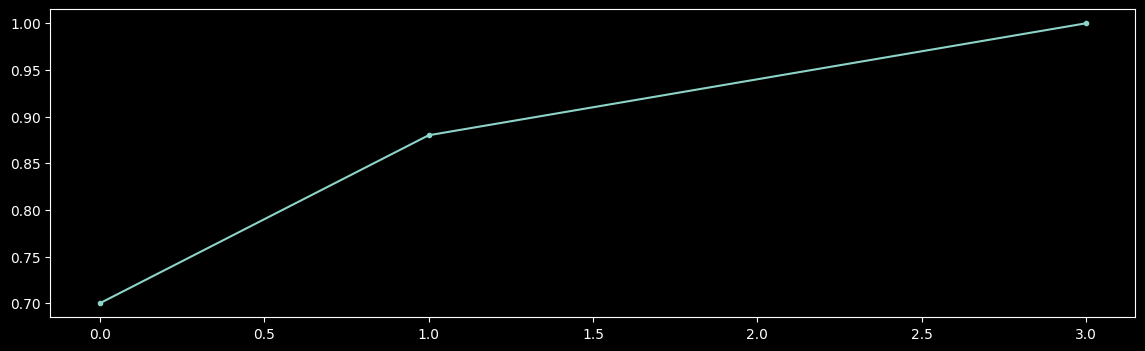

In [28]:
history = np.array(history1)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")
plt.show()

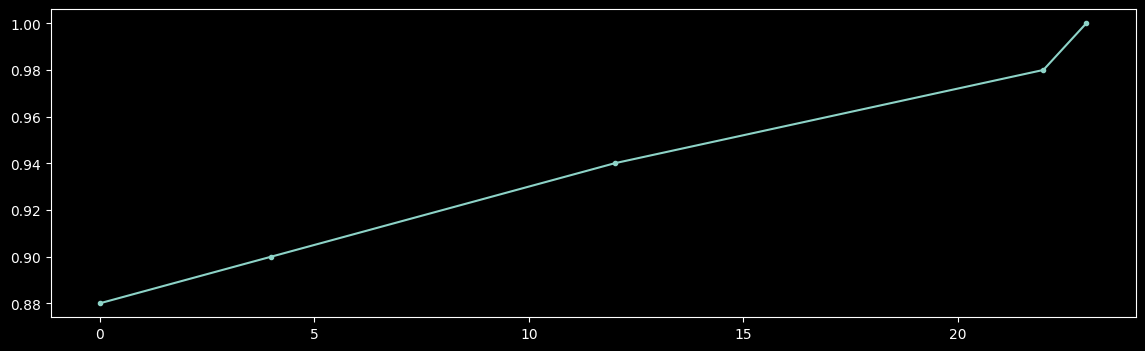

In [29]:
history = np.array(history2)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")
plt.show()

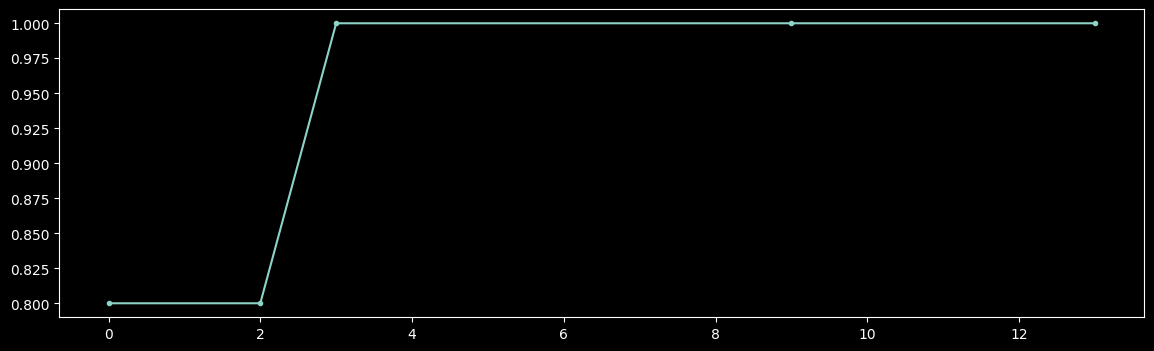

In [30]:
history = np.array(history3)
plt.figure(figsize=(14, 4))
plt.plot(history[:, 0], history[:, 1], marker=".")
plt.show()

In [31]:
n_games = 50

In [32]:
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=pure_random)(best_solution1)
    * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=gabriele)(best_solution1) * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=optimal)(best_solution1) * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=new_optimal)(best_solution1)
    * 100,
    "%",
)

92.0 %
100.0 %
100.0 %
87.0 %


In [33]:
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=pure_random)(best_solution2)
    * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=gabriele)(best_solution2) * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=optimal)(best_solution2) * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=new_optimal)(best_solution2)
    * 100,
    "%",
)

97.0 %
100.0 %
100.0 %
91.0 %


In [34]:
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=pure_random)(best_solution3)
    * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=gabriele)(best_solution3) * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=optimal)(best_solution3) * 100,
    "%",
)
print(
    fitness1(n_games=n_games, n_rows=N_ROWS, strategy2=new_optimal)(best_solution3)
    * 100,
    "%",
)

87.0 %
100.0 %
90.0 %
100.0 %
